### Importing libraries

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 
from numpy import array
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.utils import plot_model
from keras.utils import to_categorical
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from PIL import Image
from os import listdir
from keras.layers import Input
from pickle import dump, load

Using TensorFlow backend.


## Preparation of Images Data / extracting feature using  VGG model

Here the features are extracted from all the images in the dataset. VGG-16 model gives out 4096 features from the input image of size 224 * 224


In [2]:
#Feature Extraction
def extract_features(directory):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('>%s' % name)
    return features

In [ ]:
directory = '/home/suman/Desktop/Flicker_dataset/Flickr8k_Dataset/Flicker8k_Dataset'
features = extract_features(directory)
print('Features of the images: %d' % len(features))

In [ ]:
dump(features, open('features.pkl', 'wb'))

## Preparing Text Data

In [3]:
def load_doc(file_name):
    # Opening the file as read only
    file = open(file_name, 'r')
    text = file.read()
    file.close()
    return text
file_name = '/home/suman/Desktop/Image_captioning/Flicker_dataset/Flickr8k_text/Flickr8k.token.txt'
text_doc = load_doc(file_name)

In [4]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping
description = load_descriptions(text_doc)
print('Loaded: %d ' % len(description))


Loaded: 8092 


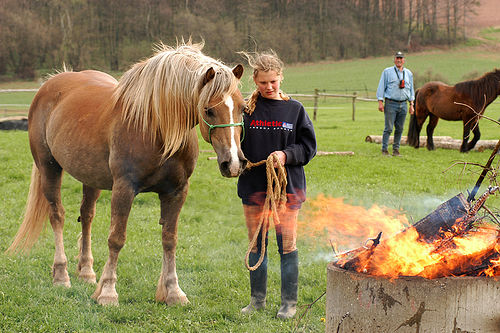

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .', 'A girl and her horse stand by a fire .', "A girl holding a horse 's lead behind a fire .", 'A man , and girl and two horses are near a contained fire .', 'Two people and two horses watching a fire .']


In [5]:
from IPython.display import display
from PIL import Image
path="/home/suman/Desktop/Image_captioning/Flicker_dataset/Flickr8k_Dataset/Flicker8k_Dataset/10815824_2997e03d76.jpg"
display(Image.open(path))
print(description['10815824_2997e03d76'])

### We need to clean the text.
- Convert all words to lowercase
- Remove all words with numbers in them
- Remove all words that are one character or less in length
- Remove all punctuation
####

In [6]:

import string
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
clean_descriptions(description)

In [7]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
vocab = to_vocabulary(description)
print('Vocabulary Size: %d' % len(vocab))

Vocabulary Size: 8763


In [8]:
def save_descriptions(description, filename):
    lines = list()
    for key, desc_list in description.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
# 
# save descriptions
save_descriptions(description, 'descriptions.txt')

In [9]:
text_file = open('/home/suman/SUMAN/descriptions.txt')

lines=text_file.readlines()
print (lines[1:10])

['1000268201_693b08cb0e girl going into wooden building\n', '1000268201_693b08cb0e little girl climbing into wooden playhouse\n', '1000268201_693b08cb0e little girl climbing the stairs to her playhouse\n', '1000268201_693b08cb0e little girl in pink dress going into wooden cabin\n', '1001773457_577c3a7d70 black dog and spotted dog are fighting\n', '1001773457_577c3a7d70 black dog and tricolored dog playing with each other on the road\n', '1001773457_577c3a7d70 black dog and white dog with brown spots are staring at each other in the street\n', '1001773457_577c3a7d70 two dogs of different breeds looking at each other on the road\n', '1001773457_577c3a7d70 two dogs on pavement moving toward each other\n']


In [10]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


In [11]:
# load training dataset
filename = '/home/suman/Desktop/Image_captioning/Flicker_dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train_set = load_set(filename)
print('Dataset: %d' % len(train_set))

Dataset: 6000


In [12]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

In [13]:
train_descriptions = load_clean_descriptions('descriptions.txt', train_set)
print('Descriptions: train_set = %d' % len(train_descriptions))

Descriptions: train_set = 6000


In [14]:
#Load Photo Feature
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features
train_features = load_photo_features('features.pkl', train_set)
print('Photos: train_set = %d' % len(train_features))

Photos: train_set = 6000


In [15]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
def max_length(descriptions):
    lines = to_lines(descriptions)
    #print(lines[0])
    return max(len(d.split()) for d in lines)
               
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [16]:
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

### Building the LSTM model

In [18]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extraction model
    input1 = Input(shape=(4096,))
    f1 = Dropout(0.5)(input1)
    f2 = Dense(256, activation='relu')(f1)
    # sequence model
    input2 = Input(shape=(max_length,))
    s1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
    s2 = Dropout(0.5)(s1)
    s3 = LSTM(256)(s2)
    # decoder model
    decoder1 = add([f2, s3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
  
    model = Model(inputs=[input1, input2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [19]:
from keras.preprocessing.text import Tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

In [21]:
# test the data generator
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
inputs, outputs = next(generator)

print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 4096)
(47, 34)
(47, 7579)



### Training the LSTM model

In [ ]:
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    # fit for one epoch
    history =model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('model_' + str(i) + '.h5')

In [22]:
dump(tokenizer, open('tokenizer.pkl', 'wb'))

### Generate New Captions for New images

In [24]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [25]:
# extract features from each photo in the directory
from numpy import argmax
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature



In [28]:
from keras.models import load_model
model = load_model('/home/suman/SUMAN/Image_caption_Generator/Model/model_9.h5')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

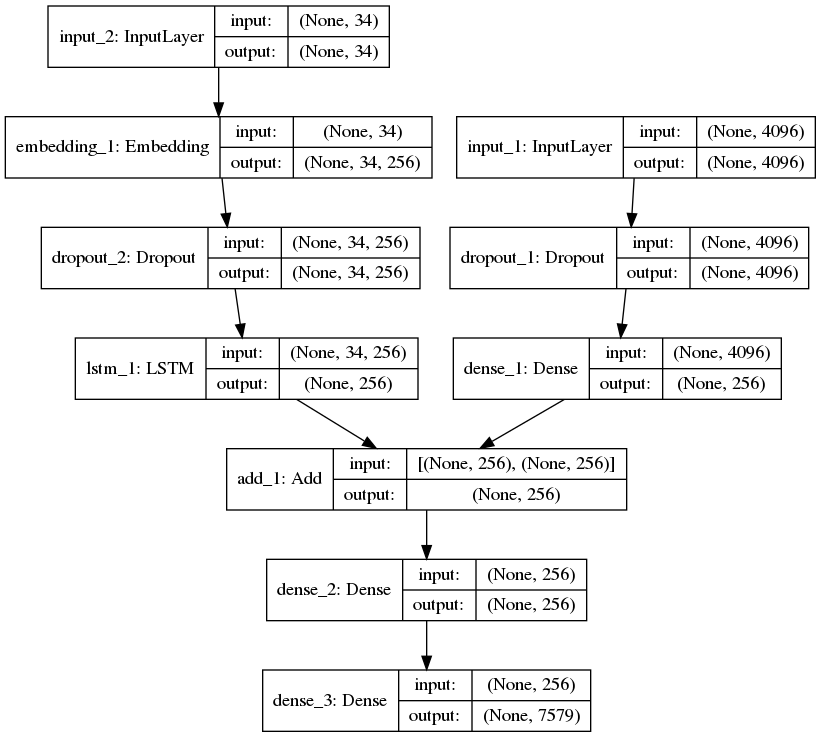

In [29]:
from IPython.display import display
from PIL import Image
path="/home/suman/SUMAN/model.png"
display(Image.open(path))

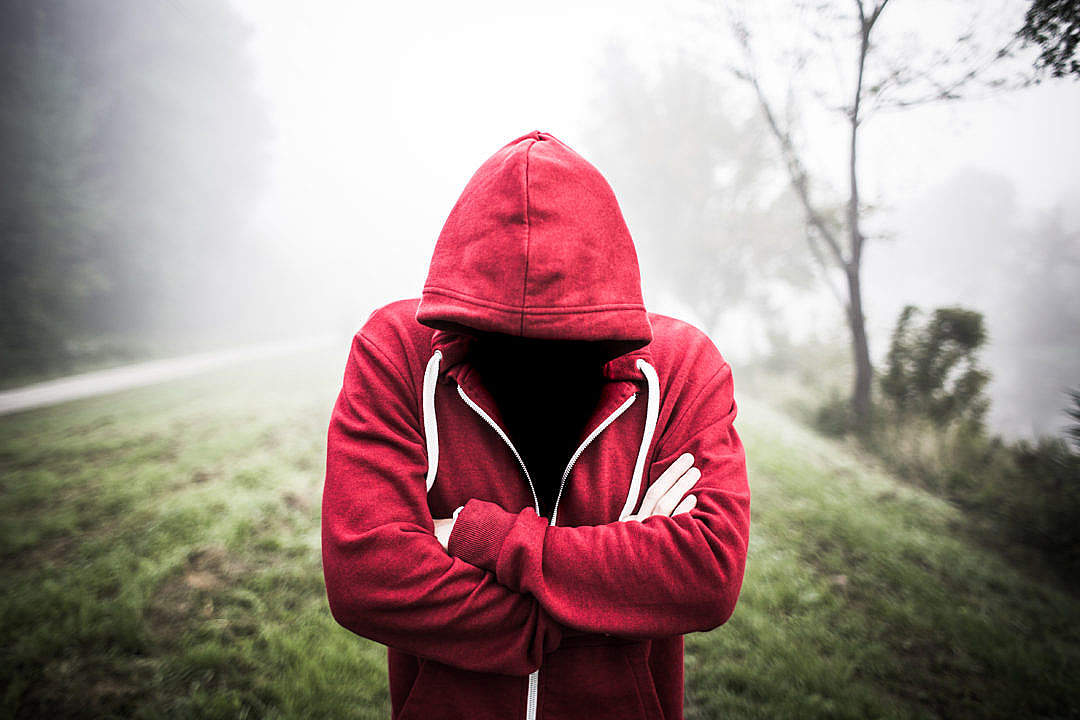


startseq man in red shirt is standing on the sidewalk endseq


In [30]:

path="/home/suman/SUMAN/Images/example.jpg"
display(Image.open(path))


photo = extract_features('/home/suman/SUMAN/Images/example.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
print(description)


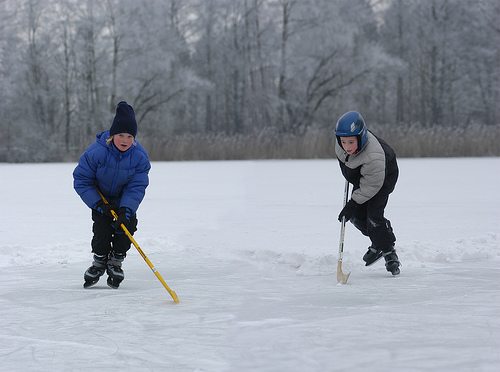

startseq two children are playing in the grass endseq


In [37]:

path="/home/suman/SUMAN/Images/3.jpg"
display(Image.open(path))


photo = extract_features('/home/suman/SUMAN/Images/3.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
print(description)



startseq man in red shirt is climbing up rocky mountain endseq


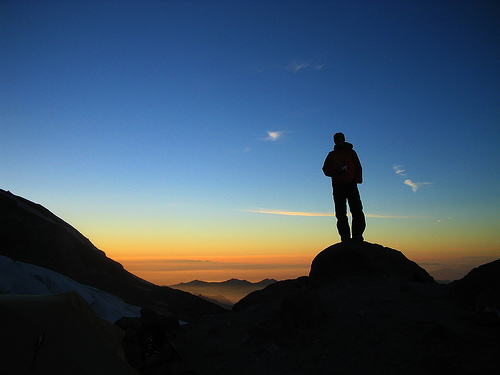

In [35]:

photo = extract_features('/home/suman/SUMAN/Images/2.jpg')
d4 = generate_desc(model, tokenizer, photo, max_length)
print(d4)
path="/home/suman/SUMAN/Images/2.jpg"
display(Image.open(path))

### Cumulative N-Gram BLEU Scores

BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations.A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

In [42]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

filename = '/home/suman/Desktop/Image_captioning/Flicker_dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
    
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.542497
BLEU-2: 0.292949
BLEU-3: 0.193336
BLEU-4: 0.083422
